In [1]:
import LDAQ #custom version of LDAQ --> should be installed properly via pip
import numpy as np
import numpy.typing as npt
import matplotlib.pyplot as plt

In [2]:
ni_task = LDAQ.national_instruments.NITask("input_task", sample_rate=2000)
ni_task

Task name: input_task
Connected devices:
	(0) - cDAQ1
	(1) - cDAQ1Mod1
Channels: []

In [3]:
device_name = "cDAQ1Mod1"
device_id = ni_task.device_list.index(device_name)

In [4]:
import nidaqmx
system = nidaqmx.system.System.local()

for device in system.devices:
    print(f"{device.name} (Type: {device.product_type}, Category: {device.product_category})")
    [print("\t", ai_ch, sep="") for ai_ch in device.ai_physical_chans]
    [print("\t", ao_ch, sep="") for ao_ch in device.ao_physical_chans]
    [print("\t", ci_ch, sep="") for ci_ch in device.ci_physical_chans]
    [print("\t", co_ch, sep="") for co_ch in device.co_physical_chans]
    [print("\t", di_line, sep="") for di_line in device.di_lines]
    [print("\t", do_line, sep="") for do_line in device.do_lines]
    [print("\t", di_port, sep="") for di_port in device.di_ports]
    [print("\t", do_port, sep="") for do_port in device.do_ports]

    print("\tBridge Ranges:") if device.ai_bridge_rngs else None
    [print("\t\t", bridge_rng, sep="") for bridge_rng in device.ai_bridge_rngs]
    print("\tCharge Ranges:") if device.ai_charge_rngs else None
    [print("\t\t", charge_rng, sep="") for charge_rng in device.ai_charge_rngs]
    print("\tCurrent Ranges:") if device.ai_current_rngs else None
    [print("\t\t", current_rng, sep="") for current_rng in device.ai_current_rngs]
    print("\tFreq Ranges:") if device.ai_freq_rngs else None
    [print("\t\t", freq_rng, sep="") for freq_rng in device.ai_freq_rngs]
    print("\tResistance Ranges:") if device.ai_resistance_rngs else None
    [print("\t\t", resistance_rng, sep="") for resistance_rng in device.ai_resistance_rngs]
    print("\tVoltage Ranges:") if device.ai_voltage_rngs else None
    [print("\t\t", voltage_rng, sep="") for voltage_rng in device.ai_voltage_rngs]

cDAQ1 (Type: cDAQ-9171, Category: ProductCategory.COMPACT_DAQ_CHASSIS)
cDAQ1Mod1 (Type: NI 9237, Category: ProductCategory.C_SERIES_MODULE)
	PhysicalChannel(name=cDAQ1Mod1/ai0)
	PhysicalChannel(name=cDAQ1Mod1/ai1)
	PhysicalChannel(name=cDAQ1Mod1/ai2)
	PhysicalChannel(name=cDAQ1Mod1/ai3)
	Bridge Ranges:
		-0.025
		0.025


In [5]:
from nidaqmx import constants

ni_task.add_channel(
    "Force", device_ind=device_id, channel_ind=0,
    sensitivity=1e3, sensitivity_units="mV/V", units="mV/V", min_val=-2, max_val=2,
    bridge_config=constants.BridgeConfiguration.FULL_BRIDGE, voltage_excit_source=constants.ExcitationSource.INTERNAL,
    voltage_excit_val=5.0, nominal_bridge_resistance=354.8
)
ni_task.add_channel(
    "Strain", device_ind=device_id, channel_ind=1,
    sensitivity=1e3, sensitivity_units='mm/mm', units='mm/mm', min_val=-0.01, max_val=0.01,
    strain_config=constants.StrainGageBridgeType.QUARTER_BRIDGE_I, voltage_excit_source=constants.ExcitationSource.INTERNAL,
    voltage_excit_val=2.5, nominal_bridge_resistance=120, gage_factor=2.0
)

ni_task

Task name: input_task
Connected devices:
	(0) - cDAQ1
	(1) - cDAQ1Mod1
Channels: ['Force', 'Strain']

In [6]:
acq_ni = LDAQ.national_instruments.NIAcquisition(task_name=ni_task, acquisition_name="NI")
acq_ni

Acquisition name:     NI
Number of channels:   0
Data channels:        []
Video channels:       []
Sample rate:          2000 Hz
Continuous mode:      False
Standalone:           True

In [7]:
def bridge_to_force(self_acq, channel_data: npt.NDArray, force_range: float = 200, sensitivity: float = 1.99979, offset: float = 0.02632) -> npt.NDArray:
    """
    Scaling function to convert bridge voltage in mV/V to force in Newtons
    Can be used in the LDAQ.Visualization object as a custom scaling function and for the post-processing of the data
    """
    # If multiple channels are visualized at once, exctract the correct channel to scale
    if len(channel_data.shape) > 1:
        ch0, bride_voltage_mV = channel_data.T #second channel is the force signal if plotting force over strain
        force = (bride_voltage_mV - offset) / sensitivity * force_range
        return np.array([ch0, force]).T 
    else:
        bride_voltage_mV = channel_data
        return (bride_voltage_mV - offset) / sensitivity * force_range

In [8]:
vis = LDAQ.Visualization(refresh_rate=100)
vis.add_lines((0,0), source="NI", channels=["Force"], t_span=5.0, function=bridge_to_force)
vis.add_lines((1,0), source="NI", channels=["Strain"], t_span=5.0)
vis.add_lines((2, 0), source="NI", channels=[("Strain", "Force")], function=bridge_to_force) #Force over strain

In [9]:
ldaq = LDAQ.Core(acquisitions=[acq_ni], visualization=vis)
ldaq

Acquisition sources (index, name):
	0 - NI

Generation sources (index, name):
	None

Additional check events:
	None

Trigger settings:
	- duration [sec]      None
	- source              None
	- channel             None
	- level               None
	- presamples          None
	- type                None

### Run the DAQ system with its GUI

In [10]:
ldaq.run(10.)

closing app
closing app


### Run after the measurement has been completed
- Extract raw acquisition data for the NI acquisition
- Extract raw data for each channel from the acquisition data

In [11]:
measurement = ldaq.get_measurement_dict()
data = measurement["NI"]
data

{'time': array([0.0000e+00, 5.0000e-04, 1.0000e-03, ..., 9.9985e+00, 9.9990e+00,
        9.9995e+00]),
 'channel_names': ['Force', 'Strain'],
 'data': array([[0.0283433 , 0.01249539],
        [0.02815257, 0.01249539],
        [0.02797675, 0.01249539],
        ...,
        [0.02782774, 0.01249539],
        [0.02825687, 0.01249539],
        [0.02842376, 0.01249539]]),
 'sample_rate': 2000}

In [12]:
time = data["time"]
fs = data["sample_rate"]
raw_data = data["data"]

force = raw_data[:, data["channel_names"].index("Force")]
strain = raw_data[:, data["channel_names"].index("Strain")]

### Post-Processing of the extracted measurement data

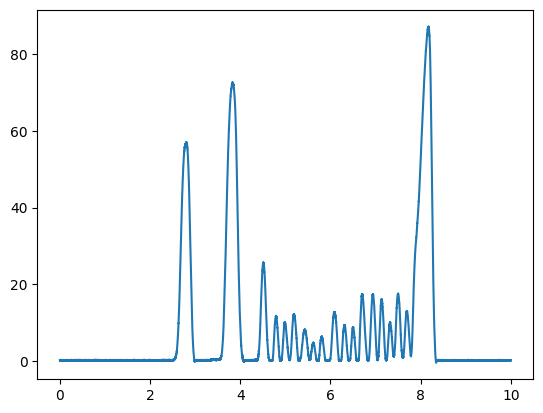

In [13]:
plt.plot(time, bridge_to_force(None, force))
#mean_force = np.mean(force)
#mean_force

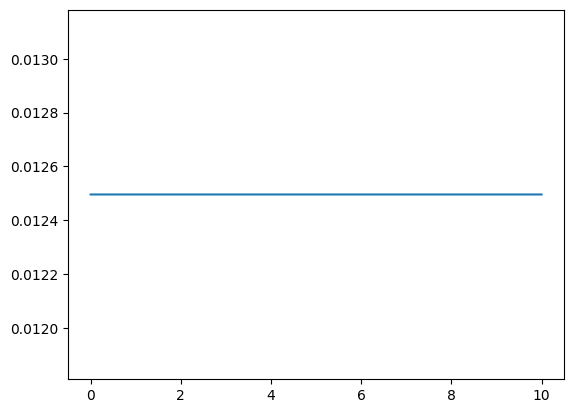

In [14]:
plt.plot(time, strain)